## Analyzing A/B Test Results of an e-commerce website

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.  For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='probability'></a>
#### Part I - Analysis of probabilities

In [28]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Reading in the dataset and taking a look at the top few rows here:

In [29]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Taking a look at general information regarding the dataset

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset

In [31]:
df.user_id.nunique()

290584

The proportion of users converted.

In [32]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match

In [33]:
df.query('group=="treatment" and landing_page != "new_page"').count()+ df.query('group!="treatment" and landing_page == "new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

Below we will remove the rows that do not meet the specifications and create a new dataframe with the accurate remaining data.

In [34]:
drop1= df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))].append(df[((df['group'] != 'treatment') & (df['landing_page'] == 'new_page'))]).index

In [35]:
df.drop(drop1, inplace=True)

In [36]:
df2 = df.copy()

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [38]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [39]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [40]:
duplicate_rows = df2[df2.duplicated(['user_id'])]

What is the row information for the repeat **user_id**? 

In [41]:
duplicate_rows

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**.

In [42]:
df2.drop_duplicates(subset='user_id', inplace=True)

What is the probability of an individual converting regardless of the page they receive?

In [43]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [44]:
control = df2.query('group == "control"')
control.converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [45]:
treatment = df2.query('group == "treatment"')
treatment.converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [46]:
df2.groupby(['landing_page']).count()/df2.shape[0]

,user_id,timestamp,group,converted
landing_page,,,,
new_page,0.500062,0.500062,0.500062,0.500062
old_page,0.499938,0.499938,0.499938,0.499938


**Observations:** The conversion rates for both control and treatment groups are very similar, therefore we cannot conclude that we have sufficient evidence that the new treatment page leads to more conversions based on the data we have readily available.

<a id='ab_test'></a>
### Part II - A/B Test

For now, we will consider we need to make the decision based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  

$$H_0: p_{old} - p_{new} \geq 0$$
$$H_1: p_{old} - p_{new} < 0$$

Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

A sample size for each page equal to the ones in **ab_data.csv** will be used.  <br><br>

The sampling distribution will be conducted for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **conversion rate** for $p_{new}$ under the null? 

In [47]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [48]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

What is $n_{new}$, the number of individuals in the treatment group?

In [49]:
n_new = df2.query('group == "treatment"')['group'].count()
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [50]:
n_old = df2.query('group == "control"')['group'].count()
n_old

145274

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [51]:
new_page_converted =[]
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17347

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [52]:
old_page_converted =[]
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17711

Finding $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [53]:
diffs = (new_page_converted/n_new) - (old_page_converted/n_old)
diffs

-0.0025351931749174605

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [54]:
p_diffs = []
for i in range(10000):
    new_simulation = np.random.binomial(n_new,p_new)/n_new
    old_simulation = np.random.binomial(n_old,p_old)/n_old
    diff = new_simulation - old_simulation 
    p_diffs.append(diff)

Plotting a histogram of the **p_diffs**.  

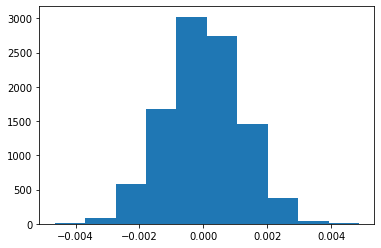

In [55]:
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [56]:
init_old_mean = df.query('group =="control"').converted.mean()
init_new_mean = df.query('group =="treatment"').converted.mean()
init_diff = init_new_mean - init_old_mean
init_diff

-0.0015790565976871451

In [57]:
p_diffs = np.array(p_diffs)

In [58]:
(p_diffs > init_diff).mean()

0.9072

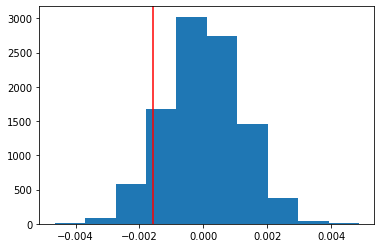

In [59]:
plt.hist(p_diffs);
plt.axvline(x=init_diff,color='red')

**Observations:** The p-value of approximately 0.9 strongly indicates that the observed difference between the means of converted control and treatment group values in the given sample falls within the data range generated under the null, therefore meaning we should not reject the null hypothesis. Normally a p-value lower than 0.05 would indicate the sample observed difference of means would fall outside the generated data for the null hypothesis.


We could also use a built-in method to achieve similar results. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [60]:
import statsmodels.api as sm

convert_old = df2.query('group =="control" and converted==1')['converted'].count()
convert_new = df2.query('group =="treatment" and converted==1')['converted'].count()
n_old = df2.query('group=="control"')['group'].count()
n_new = df2.query('group=="treatment"')['group'].count()

Using `stats.proportions_ztest` to compute your test statistic and p-value. 

In [61]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old,n_new], alternative='smaller')

(1.3109241984234394, 0.9050583127590245)

**Observations:** The 1.31 z-score here indicates that the data points collected in the z-test are 1.31 standard deviations above the mean of the group they were collected from. The p-value is almost identical to the one we obtained in part II of the project, reinforcing the idea that we should not reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will show that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, what type of regression should we be looking at?

**Answer:** Logistic regression as the variable we are looking at is binary.

Creating a column for the intercept in df2, and creating a dummy variable column for which page each user received.  

In [62]:
df2[['old_page','ab_page']] = pd.get_dummies(df2['group'])
df2['intercept']=1

Using **statsmodels** to instantiate the regression model on the two columns mentioned above, then fitting the model to predict whether or not an individual converts. 

In [63]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Providing the summary of the model below.

In [64]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-04-08 17:53 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  

**Answer:** The p value associated with the ab_page variable is 0.1899. This is based on the following null and alternative hypotheses:
$$H_0: p_{old} = p_{new}$$
$$H_1: p_{old} \neq p_{new}$$
Of course this should be different from the p value of 0.9 obtained in part II as this would be obtained based on the following null and alternative hypotheses:
$$H_0: p_{old} - p_{new} \geq 0$$
$$H_1: p_{old} - p_{new} < 0$$
To conclude - the 0.1899 p value is not statiscally significant in predicting the likelihood of changes in the average conversion rates based on the new page provided.

Let's consider other things that might influence whether or not an individual converts. Are there any disadvantages to adding additional terms into your regression model?

**Answer:** 

Pros:

- The addition of other factors would be welcomed in this case as the pseudo R squared value in this instance is 0, meaning that the likelihood for changes in the coversion rate is not linked at all to the new page. In this case the addition of  multiple other factors may explain the variability of the conversion rate better.  
- Additional factors may also enable the usage of higher order terms in order to obtain an increased pseudo R squared value

Cons:

- With an increased number of additional factors our model will have an increased chance of displaying multicolinearity between factors, thus skewing the final results and generating extra work in finding the Variance Inflation Factors and removing some of these for a better fit

Now along with testing if the conversion rate changes for different pages, also adding an effect based on which country a user lives in by using the **countries.csv** file.

In [65]:
df_countries = pd.read_csv('countries.csv')
df_countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [66]:
df_joined = df2.set_index('user_id').join(df_countries.set_index('user_id'), on='user_id', how='inner')
df_joined[['CA','UK','US']] = pd.get_dummies(df_joined['country'])


Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  

In [67]:
log1 = sm.Logit(df_joined['converted'], df_joined[['intercept','CA','US']])
res1 = log1.fit()
res1.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-04-08 17:53 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

In [68]:
np.exp(res1.params)

intercept    0.137132
CA           0.950546
US           0.990133
dtype: float64

**Observations**: Based on the results of the logistic regression we can safely conclude that the country variables do not have a statistical significance predicting the likelihood of changes in the average conversion rates. Moreover, the pseudo R squared value is 0, meaning that the variability of the conversion rate is not explained well by the country variables.

## Conclusions

Based on the tests we ran on the data provided, here are the conclusions:

- The old page should be kept as there was not enough statistically significant evidence to reject the null hyopthesis in the A/B test and z test done
- The regression models created conclude that the new page variable and other factors such as countries are not statiscally significant in predicting the likelihood of changes in the average conversion rates.